In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from statsmodels.api import OLS, add_constant
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import roc_auc_score
import joblib

sns.set_style("white")
np.random.seed(42)
pd.options.display.float_format = '{:,.4f}'.format

with pd.HDFStore('data/tuning_sklearn_gbm.h5') as store:
    test_feature_data = store['holdout/features']
    test_features = test_feature_data.columns
    test_target = store['holdout/target']

In [2]:
# because of stored data
class OneStepTimeSeriesSplit:
    pass

gridsearch_result = joblib.load('results/sklearn_gbm_gridsearch.joblib')

In [3]:
pd.Series(gridsearch_result.best_params_)

learning_rate             0.1000
max_depth                 8.0000
max_features              1.0000
min_impurity_decrease     0.0100
min_samples_split        50.0000
n_estimators            100.0000
subsample                 1.0000
dtype: float64

In [4]:
f'{gridsearch_result.best_score_:.4f}'

'0.5472'

In [5]:
# Evaluate best model
# Test on hold-out set
best_model = gridsearch_result.best_estimator_
idx = pd.IndexSlice
test_dates = sorted(test_feature_data.index.get_level_values('date').unique())
auc = {}
for i, test_date in enumerate(test_dates):
    test_data = test_feature_data.loc[idx[:, test_date], :]
    preds = best_model.predict(test_data)
    auc[i] = roc_auc_score(y_true=test_target.loc[test_data.index], y_score=preds)
auc = pd.Series(auc)
auc.head()

0   0.5057
1   0.5228
2   0.5219
3   0.4837
4   0.5360
dtype: float64

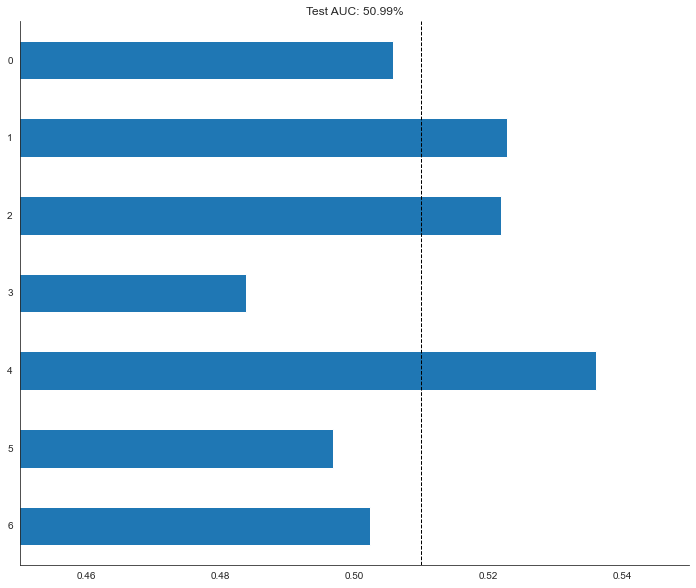

In [6]:
ax = auc.sort_index(ascending=False).plot.barh(xlim=(.45, .55), title=f'Test AUC: {auc.mean():.2%}',
                                               figsize=(12, 10))
ax.axvline(auc.mean(), ls='--', lw=1, c='k')
sns.despine()

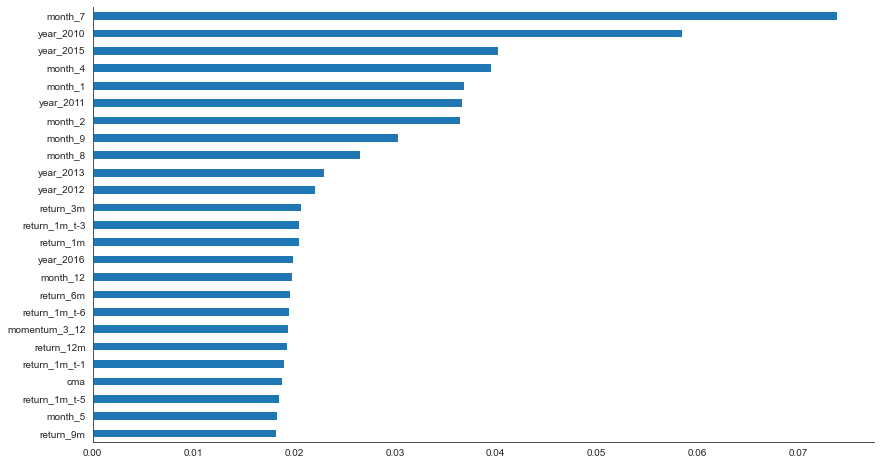

In [7]:
(pd.Series(best_model.feature_importances_, index=test_features).sort_values().tail(25)
 .plot.barh(figsize=(14, 8)))
sns.despine()

In [8]:
# CV Train-Test Scores
results = pd.DataFrame(gridsearch_result.cv_results_).drop('params', axis=1)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   mean_fit_time                32 non-null     float64
 1   std_fit_time                 32 non-null     float64
 2   mean_score_time              32 non-null     float64
 3   std_score_time               32 non-null     float64
 4   param_learning_rate          32 non-null     object 
 5   param_max_depth              32 non-null     object 
 6   param_max_features           32 non-null     object 
 7   param_min_impurity_decrease  32 non-null     object 
 8   param_min_samples_split      32 non-null     object 
 9   param_n_estimators           32 non-null     object 
 10  param_subsample              32 non-null     object 
 11  split0_test_score            32 non-null     float64
 12  split1_test_score            32 non-null     float64
 13  split2_test_score     

In [9]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_split,param_n_estimators,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,47.1551,1.9059,0.0124,0.0027,0.0100,4,sqrt,0.0100,10,100,...,0.6941,0.6883,0.6961,0.6975,0.6978,0.6999,0.7016,0.7007,0.6946,0.0053
1,54.2383,3.4047,0.0121,0.0035,0.0100,4,sqrt,0.0100,10,100,...,0.6947,0.6907,0.6960,0.6971,0.6957,0.7013,0.7026,0.6976,0.6946,0.0044
2,46.6259,2.6857,0.0104,0.0010,0.0100,4,sqrt,0.0100,50,100,...,0.6964,0.6937,0.6991,0.7037,0.6991,0.6914,0.7011,0.7006,0.6942,0.0069
3,54.1368,2.5060,0.0111,0.0023,0.0100,4,sqrt,0.0100,50,100,...,0.6937,0.6914,0.6929,0.7015,0.6960,0.7061,0.6997,0.7021,0.6944,0.0066
4,15.4527,1.4937,0.0145,0.0055,0.0100,4,1,0.0100,10,100,...,0.6398,0.6493,0.6502,0.6540,0.6403,0.6461,0.6527,0.6533,0.6478,0.0046


In [10]:
# Get parameter values & mean test scores
test_scores = results.filter(like='param').join(results[['mean_test_score']])
test_scores = test_scores.rename(columns={c: '_'.join(c.split('_')[1:]) for c in test_scores.columns})
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   learning_rate          32 non-null     object 
 1   max_depth              32 non-null     object 
 2   max_features           32 non-null     object 
 3   min_impurity_decrease  32 non-null     object 
 4   min_samples_split      32 non-null     object 
 5   n_estimators           32 non-null     object 
 6   subsample              32 non-null     object 
 7   test_score             32 non-null     float64
dtypes: float64(1), object(7)
memory usage: 2.1+ KB


In [11]:
params = test_scores.columns[:-1].tolist()
test_scores = test_scores.set_index('test_score').stack().reset_index()
test_scores.columns= ['test_score', 'parameter', 'value']
test_scores.head()

,test_score,parameter,value
0,0.5115,learning_rate,0.0100
1,0.5115,max_depth,4
2,0.5115,max_features,sqrt
3,0.5115,min_impurity_decrease,0.0100
4,0.5115,min_samples_split,10


In [12]:
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_score  224 non-null    float64
 1   parameter   224 non-null    object 
 2   value       224 non-null    object 
dtypes: float64(1), object(2)
memory usage: 5.4+ KB


In [13]:
def get_test_scores(df):
    """Select parameter values and test scores"""
    data = df.filter(like='param').join(results[['mean_test_score']])
    return data.rename(columns={c: '_'.join(c.split('_')[1:]) for c in data.columns})

In [14]:
plot_data = get_test_scores(results).drop('min_impurity_decrease', axis=1)
plot_params = plot_data.columns[:-1].tolist()
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   learning_rate      32 non-null     object 
 1   max_depth          32 non-null     object 
 2   max_features       32 non-null     object 
 3   min_samples_split  32 non-null     object 
 4   n_estimators       32 non-null     object 
 5   subsample          32 non-null     object 
 6   test_score         32 non-null     float64
dtypes: float64(1), object(6)
memory usage: 1.9+ KB


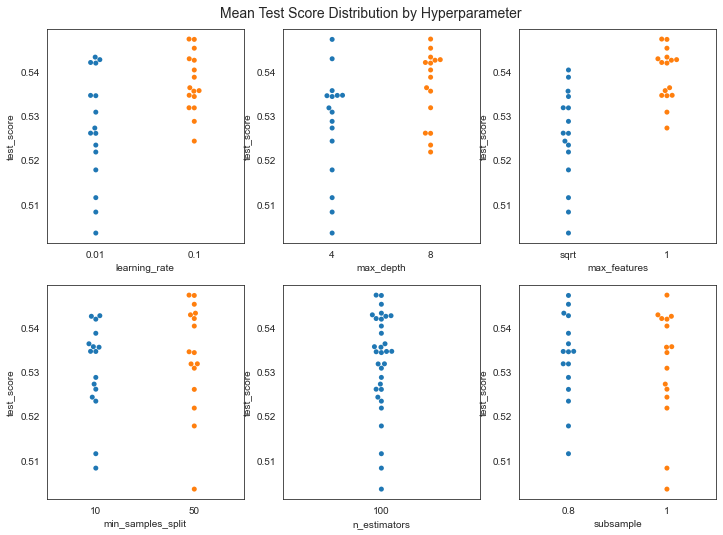

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
axes = axes.flatten()

for i, param in enumerate(plot_params):
    sns.swarmplot(x=param, y='test_score', data=plot_data, ax=axes[i])

fig.suptitle('Mean Test Score Distribution by Hyperparameter', fontsize=14)
fig.subplots_adjust(top=.94)
fig.savefig('sklearn_cv_scores_by_param', dpi=300);

In [16]:
# Dummy-encode parameters
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   test_score                  32 non-null     float64
 1   learning_rate_0.01          32 non-null     uint8  
 2   learning_rate_0.1           32 non-null     uint8  
 3   max_depth_4                 32 non-null     uint8  
 4   max_depth_8                 32 non-null     uint8  
 5   max_features_1              32 non-null     uint8  
 6   max_features_sqrt           32 non-null     uint8  
 7   min_impurity_decrease_0.01  32 non-null     uint8  
 8   min_samples_split_10        32 non-null     uint8  
 9   min_samples_split_50        32 non-null     uint8  
 10  n_estimators_100            32 non-null     uint8  
 11  subsample_0.8               32 non-null     uint8  
 12  subsample_1.0               32 non-null     uint8  
dtypes: float64(1), uint8(12)
memory usage

In [17]:
# Build Regression Tree
reg_tree = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=4, min_samples_split=5,
                                 min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features=None,
                                 random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0,)
gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(criterion='mse', max_depth=4, min_samples_leaf=10,
                      min_samples_split=5, random_state=42)

In [18]:
reg_tree.feature_importances_

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

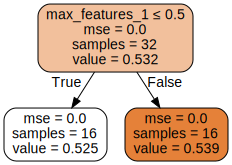

In [19]:
# Visualize Tree
out_file = 'results/gbm_sklearn_tree.dot'
dot_data = export_graphviz(reg_tree, out_file=out_file, feature_names=gbm_features, max_depth=4, filled=True,
                          rounded=True, special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [20]:
# Compute Feature Importance
reg_tree = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features=None, random_state=42,
                                 max_leaf_nodes=None, min_impurity_decrease=0.0,)

gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(criterion='mse', random_state=42)

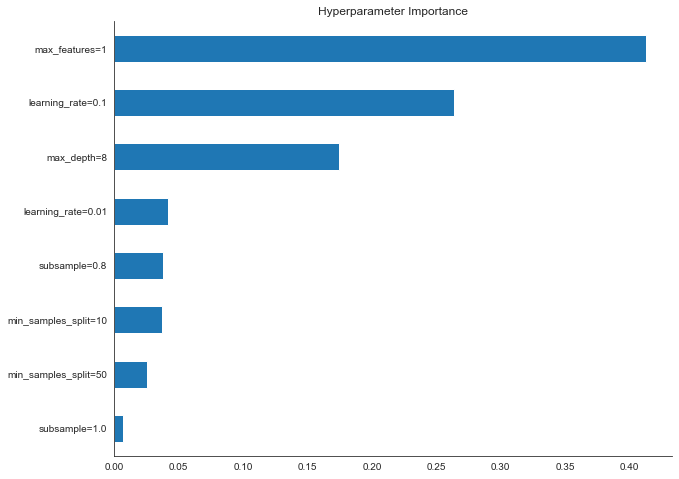

In [23]:
gbm_fi = (pd.Series(reg_tree.feature_importances_, index=gbm_features).sort_values(ascending=False))
gbm_fi = gbm_fi[gbm_fi > 0]
idx = [p.split('_') for p in gbm_fi.index]
gbm_fi.index = ['_'.join(p[:-1]) + '=' + p[-1] for p in idx]
gbm_fi.sort_values().plot.barh(figsize=(10,8))
plt.title('Hyperparameter Importance')
sns.despine()

In [22]:
# Run linear regression
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=True)

model = OLS(endog=data.test_score, exog=add_constant(data.drop('test_score', axis=1))).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             test_score   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     21.28
Date:                Thu, 18 May 2023   Prob (F-statistic):           1.93e-08
Time:                        23:54:21   Log-Likelihood:                 125.16
No. Observations:                  32   AIC:                            -238.3
Df Residuals:                      26   BIC:                            -229.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5291 